# Anomaly detection in time-series
This notebook demonstrates anomaly detection in time series using various techniques such as:

- Statistical methods
- Machine learning models
- Deep learning models
- Spectrogram-based models

In [1]:
%load_ext autoreload
%autoreload 2

## Necessary imports

In [2]:
import os
import json
from typing import List

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Custom modules
import sys
sys.path.append('..')

from models import Network, LSTMWithEncoder
from data_preprocessing import DataPreprocessor, SimpleDataSet, DataLoaderNAB

torch.set_default_dtype(torch.float32)
%matplotlib inline

## Data
To compare each model, we will use real-life data from the NAB dataset (realAdExchange/exchange-3_cpc_results). The NAB dataset can be found [here](https://github.com/numenta/NAB).

The specific data used in this notebook is from the `realAdExchange/exchange-3_cpc_results` file. This dataset contains timestamped values representing the cost-per-click (CPC) results over a period of time. The dataset includes:

- `timestamp`: The date and time of the recorded value.
- `value`: The CPC value recorded at the corresponding timestamp.

We will use this data to train and evaluate our anomaly detection models.


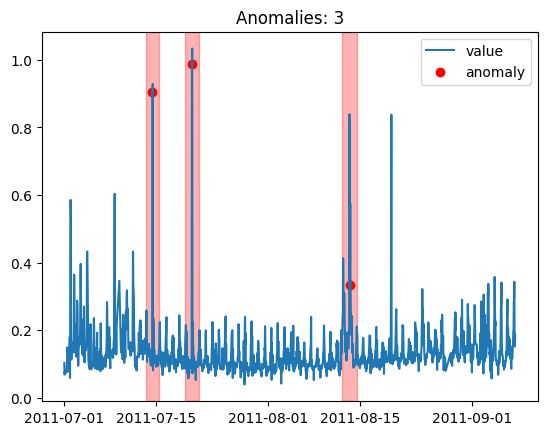

In [3]:
df, anomaly_times, anomaly_windows = DataLoaderNAB.load_data('data.csv', 'anomaly_times.json', 'windows.json')

DataLoaderNAB.plot_series(df, anomaly_times, anomaly_windows)

## Methods

In [60]:
n_ar = 5
n_hist = 3
batch_size = 0.5 # percentage
test_size = 0.3 # percentage\\
to_tensor = lambda x: [torch.tensor(i, dtype=torch.float32) for i in x]

U = []
Y = df["value"].values

def create_NARX_dataset(U, Y, n_ar=0, n_hist=0, n_b=0, n_hist_u=0, test_size=0.1):
    to_tensor = lambda x: [torch.tensor(i, dtype=torch.float32) for i in x]

    Xdata, Ydata, Hdata = DataPreprocessor.create_NARX_model(U, Y, n_ar=n_ar, n_b=n_b, return_history=True, n_hist_y=n_hist, n_hist_u=n_hist_u, output_as_tuple=False)
    Xdata, Ydata, Hdata = to_tensor([Xdata, Ydata, Hdata])
    Xtrain, Xval, Ytrain, Yval, Htrain, Hval = train_test_split(Xdata, Ydata, Hdata, test_size=test_size, shuffle=True)

    return Xtrain, Xval, Ytrain, Yval, Htrain, Hval, Xdata, Ydata, Hdata

def create_dataloaders(Xtrain, Xval, Ytrain, Yval, Htrain, Hval, batch_size=10):
    n_samples = len(Ytrain)
    n_batch = round(batch_size * n_samples)
    assert n_batch > 1, "Batch normalization of the model requires batch size greater than 1!"

    train_dl_net = DataLoader(SimpleDataSet(Xtrain, Ytrain), batch_size=n_batch, shuffle=True)
    train_dl_lstm = DataLoader(SimpleDataSet((Xtrain, Htrain), Ytrain), batch_size=n_batch, shuffle=True)
    val_dl_net = DataLoader(SimpleDataSet(Xval, Yval), batch_size=n_batch, shuffle=True)
    val_dl_lstm = DataLoader(SimpleDataSet((Xval, Hval), Yval), batch_size=n_batch, shuffle=True)

    return train_dl_net, train_dl_lstm, val_dl_net, val_dl_lstm

Xtrain, Xval, Ytrain, Yval, Htrain, Hval, Xdata, Ydata, Hdata = create_NARX_dataset(U, Y, n_ar, n_hist, n_b=0, n_hist_u=0, test_size=test_size)
train_dl_net, train_dl_lstm, val_dl_net, val_dl_lstm = create_dataloaders(Xtrain, Xval, Ytrain, Yval, Htrain, Hval, batch_size=batch_size)


n_burn_in = df['value'].shape[0] - Xdata.shape[0] # number of burn-in samples

In [61]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model_lstm to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        if isinstance(X, torch.Tensor):
            pred = model(X)
        else:
            pred = model(*X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss = loss.item()
    return loss


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            if isinstance(X, torch.Tensor):
                pred = model(X)
            else:
                pred = model(*X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

def fit_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs = 1, log_interval = None):
    loss_train = []
    loss_val = []
    if not log_interval:
        log_interval = round(epochs * 0.1)
    for t in range(epochs):
        loss_t = train_loop(train_dataloader, model, loss_fn, optimizer)
        loss_v = test_loop(test_dataloader, model, loss_fn)
        loss_train.append(loss_t)
        loss_val.append(loss_v)

        if t % log_interval == 0:
            print(f"Epoch {t+1}, Train loss = {loss_t}, Test loss = {loss_v} \n-------------------------------")
    return loss_train, loss_val

In [62]:
# Create models
n_output = 1 if Ytrain.ndim == 1 else Ytrain.shape[-1]
model_net = Network([n_ar, 32, n_output])
model_lstm = LSTMWithEncoder(
    input_size=1,  # number of features in a time step --> input is univariate
    hidden_size=max(n_hist * 5, 40),
    output_size=n_output,
    history_size=n_hist,
)

loss_fn = nn.MSELoss()
optimizer_net = torch.optim.Adam(model_net.parameters())
optimizer_lstm = torch.optim.Adam(model_lstm.parameters())
epochs = 101
loss_train = []
loss_val = []

loss_train_lstm, loss_val_lstm = fit_loop(train_dl_lstm, val_dl_lstm, model_lstm, loss_fn, optimizer_lstm, epochs)
loss_train_net, loss_val_net = fit_loop(train_dl_net, val_dl_net, model_net, loss_fn, optimizer_net, epochs)


Epoch 1, Train loss = 0.04498888552188873, Test loss = 0.0401928685605526 
-------------------------------
Epoch 11, Train loss = 0.005467789247632027, Test loss = 0.02715182863175869 
-------------------------------
Epoch 21, Train loss = 0.003165124449878931, Test loss = 0.019740648567676544 
-------------------------------
Epoch 31, Train loss = 0.002938636112958193, Test loss = 0.010821593925356865 
-------------------------------
Epoch 41, Train loss = 0.004033164121210575, Test loss = 0.006123073399066925 
-------------------------------
Epoch 51, Train loss = 0.0034775470849126577, Test loss = 0.005574541166424751 
-------------------------------
Epoch 61, Train loss = 0.003233846975490451, Test loss = 0.00547216460108757 
-------------------------------
Epoch 71, Train loss = 0.002649862552061677, Test loss = 0.005420065484941006 
-------------------------------
Epoch 81, Train loss = 0.0038290112279355526, Test loss = 0.005346930585801601 
-------------------------------
Epoch

In [63]:
model_net.eval()
with torch.no_grad():
    y_pred_net = model_net(Xdata)
    y_pred_lstm = model_lstm(Xdata, Hdata)

pred_error_lstm = np.squeeze(Ydata - y_pred_lstm).numpy()
pred_error_net = np.squeeze(Ydata - y_pred_net).numpy()

In [64]:
def plot_results_training(axs, y_pred, loss_train, loss_val, model_name, color):
    # plot predicted result
    axs[0].plot(y_pred, label=f'Predicted time series - {model_name}', color=color)
    axs[0].set_xlabel('time index')
    axs[0].legend()

    axs[1].plot(np.array(loss_train), label=f'Train loss - {model_name}', color=color, linestyle='solid')
    axs[1].plot(np.array(loss_val), label=f'Validation loss - {model_name}', color=color, linestyle='dashed')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    return axs

def plot_results_timeseries(fig:go.Figure, df, y_pred, pred_error, anomaly_times, anomaly_windows, n_lag):
    # Add time series
    fig.add_trace(go.Scatter(x=df["timestamp"], y=df["value"], mode='lines', name='Time series'))

    # Add reconstruction
    fig.add_trace(go.Scatter(x=df["timestamp"][n_lag:], y=np.squeeze(y_pred.numpy()), mode='lines', name='Prediction'))

    # Add prediction error
    fig.add_trace(go.Scatter(x=df["timestamp"][n_lag:], y=pred_error, mode='lines', name='Prediction error'))
    # Add anomaly windows
    for window in anomaly_windows:
        fig.add_shape(
            type="rect",
            x0=window[0],
            y0=-float('inf'),
            x1=window[1],
            y1=float('inf'),
            fillcolor="red",
            opacity=0.3,
            line_width=0,
        )
    # Add anomalies
    for anomaly_time in anomaly_times:
        fig.add_shape(
            type="line",
            x0=anomaly_time,
            y0=-float('inf'),
            x1=anomaly_time,
            y1=float('inf'),
            line=dict(dash="dash")
        )
    fig.add_trace(go.Scatter(
        x=anomaly_times,
        y=np.zeros_like(anomaly_times, dtype=np.float32),
        mode='markers',
        marker=dict(color='black'),
        name='Anomaly'
    ))

    fig.update_layout(title='Time Series with Prediction Error and Anomalies', xaxis_title='Timestamp', yaxis_title='Value')
    return fig


array([<Axes: xlabel='time index'>, <Axes: xlabel='Epochs'>], dtype=object)

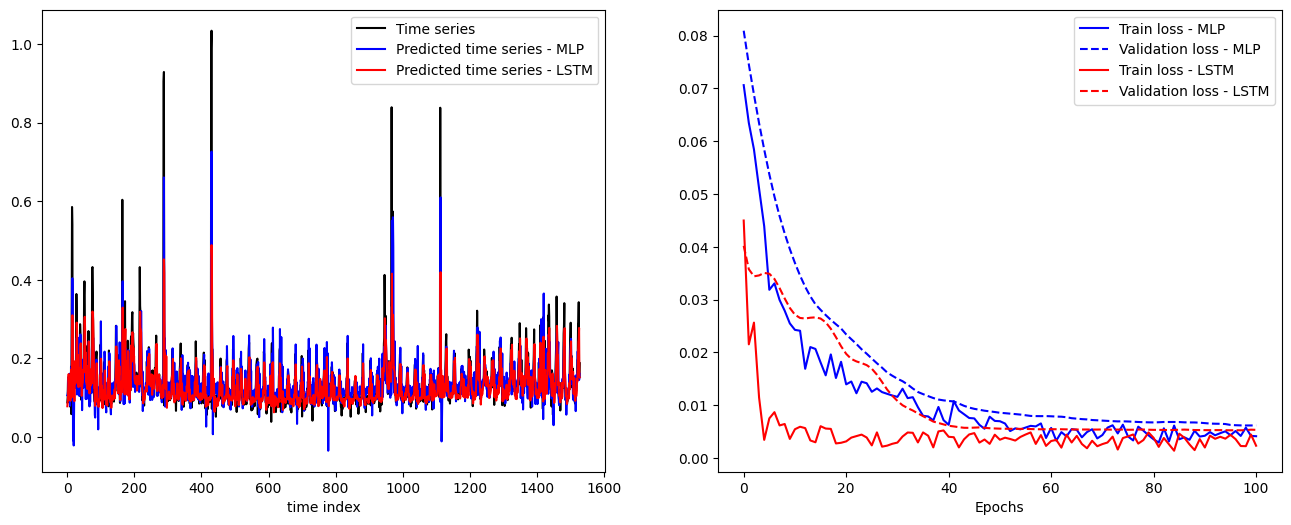

In [65]:
fig1, axs = plt.subplots(1, 2, figsize=(16, 6))
# Plot true time series once
axs[0].plot(Ydata, color='k', label='Time series')

plot_results_training(axs, y_pred_net, loss_train_net, loss_val_net, "MLP", color='b')
plot_results_training(axs, y_pred_lstm, loss_train_lstm, loss_val_lstm, "LSTM", color='r')

In [66]:
fig = go.Figure()
fig = plot_results_timeseries(fig, df, y_pred_lstm, pred_error_lstm, anomaly_times, anomaly_windows, n_burn_in)
fig.show()

In [67]:
fig = go.Figure()
fig = plot_results_timeseries(fig, df, y_pred_net, pred_error_net, anomaly_times, anomaly_windows, n_burn_in)
fig.show()